In [15]:
from transformers import BeitImageProcessor, BeitForImageClassification
from PIL import Image
import requests
import matplotlib.pyplot as plt
import json
import torch
import glob
import pickle
from tqdm import tqdm

In [2]:
processor = BeitImageProcessor.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k')
model = BeitForImageClassification.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k')

In [3]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
# model predicts one of the 21,841 ImageNet-22k classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: tabby, tabby_cat


In [2]:
import requests
import torch
from PIL import Image
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation

In [3]:
torch.cuda.set_device(0)

In [8]:
# load Mask2Former fine-tuned on COCO panoptic segmentation
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-coco-panoptic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-coco-panoptic").to("cuda")

In [9]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
inputs = processor(images=image, return_tensors="pt").to("cuda")

with torch.no_grad():
    outputs = model(**inputs)

# model predicts class_queries_logits of shape `(batch_size, num_queries)`
# and masks_queries_logits of shape `(batch_size, num_queries, height, width)`
class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits

# you can pass them to processor for postprocessing
result = processor.post_process_panoptic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
# we refer to the demo notebooks for visualization (see "Resources" section in the Mask2Former docs)
predicted_panoptic_map = result["segmentation"]

`label_ids_to_fuse` unset. No instance will be fused.


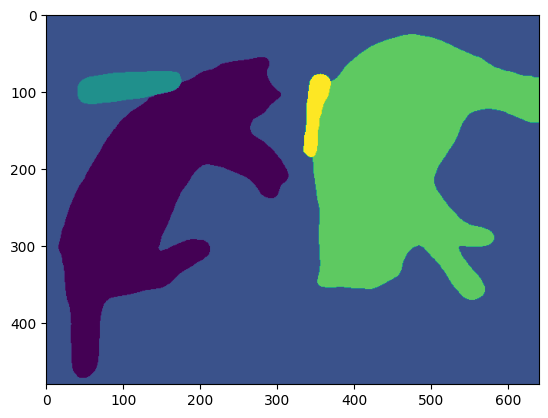

In [11]:
plt.imshow(predicted_panoptic_map.cpu())

In [11]:
def get_mask(segmentation, segment_id):
  # print("Visualizing mask for:", model.config.id2label[segment_to_label[segment_id]])

  mask = (segmentation.numpy() == segment_id)
  visual_mask = (mask * 255).astype(np.uint8)
  visual_mask = Image.fromarray(visual_mask)

  return visual_mask

In [16]:
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm

def draw_panoptic_segmentation(segmentation, segments_info):
    # get the used color map
    viridis = cm.get_cmap('viridis', torch.max(segmentation))
    
    fig, ax = plt.subplots()
    ax.imshow(segmentation)
    instances_counter = defaultdict(int)
    handles = []
    # for each segment, draw its legend
    for segment in segments_info:
        segment_id       = segment['id']
        segment_label_id = segment['label_id']
        segment_label    = model.config.id2label[segment_label_id]
        
        label = f"{segment_label}-{instances_counter[segment_label_id]}"
        instances_counter[segment_label_id] += 1
        color = viridis(segment_id)
        handles.append(mpatches.Patch(color=color, label=label))
        
    ax.legend(handles=handles)

/tmp/ipykernel_89158/3659529247.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', torch.max(segmentation))


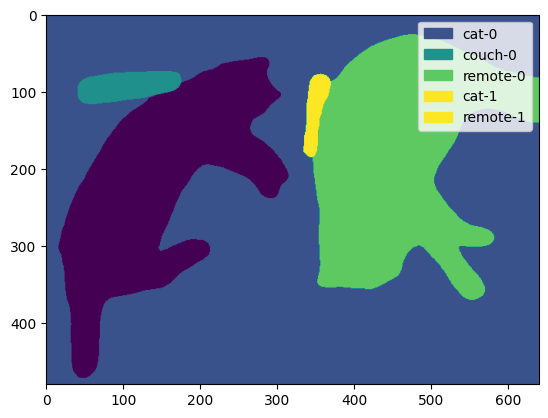

In [17]:
draw_panoptic_segmentation(**result)

In [6]:
result

{'segmentation': tensor([[2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         ...,
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2]], dtype=torch.int32),
 'segments_info': [{'id': 1,
   'label_id': 15,
   'was_fused': False,
   'score': 0.981745},
  {'id': 2, 'label_id': 57, 'was_fused': False, 'score': 0.978469},
  {'id': 3, 'label_id': 65, 'was_fused': False, 'score': 0.997983},
  {'id': 4, 'label_id': 15, 'was_fused': False, 'score': 0.978765},
  {'id': 5, 'label_id': 65, 'was_fused': False, 'score': 0.991965}]}

In [34]:
with open('/home/yangwenhao/.cache/huggingface/hub/models--facebook--mask2former-swin-large-coco-panoptic/snapshots/85b535928a783691eaf27467a573b26d543336ea/config.json', 'r') as f:
    configs = json.load(f)
    
# configs['id2label']

In [18]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

print(image)
inputs = processor(images=image, return_tensors="pt")

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480 at 0x7F7C9F57FF40>


In [13]:
"cocodataset.org/val2017/000000039769.jpg".rstrip('.jpg')

'cocodataset.org/val2017/000000039769'

In [ ]:
img_reg = "data/Tourist_Attraction/*.jpg"
imgs = glob.glob(img_reg)

for img_path in tqdm(imgs, total=len(imgs), ncols=50):
    image = Image.open(img_path)
    inputs = processor(images=image.convert("RGB"), return_tensors="pt").to("cuda")

    with torch.no_grad():
        outputs = model(**inputs)

    # you can pass them to processor for postprocessing
    result = processor.post_process_panoptic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
    
    save_file = img_path.replace('jpg', 'pickle')
    save_file = save_file.replace('Tourist_Attraction', 'Tourist_Attraction_Pickle')
    with open(save_file, 'wb') as f:
        pickle.dump(result, f)
        
# we refer to the demo notebooks for visualization (see "Resources" section in the Mask2Former docs)
# predicted_panoptic_map = result["segmentation"]

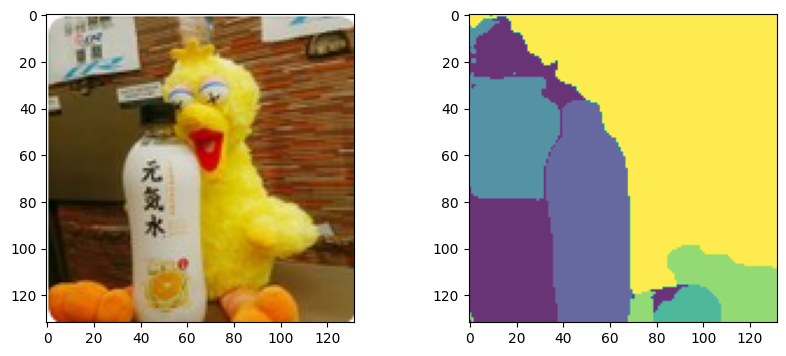

In [19]:
plt.figure(figsize=(10, 4))

plt.subplot(1,2,1)
plt.imshow(image)

plt.subplot(1,2,2)
plt.imshow(predicted_panoptic_map, alpha=0.8)

/tmp/ipykernel_89158/3659529247.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', torch.max(segmentation))


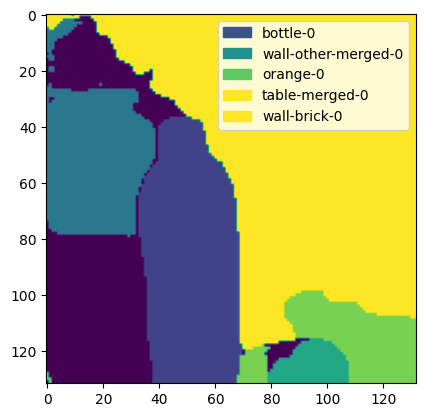

In [20]:
draw_panoptic_segmentation(**result)

In [39]:
for i in result['segments_info']:
    print("label: {:>20s}, \tscore: {:>6.4f}".format(configs['id2label'][str(i['label_id'])], i['score']))

label:               bottle, 	score: 0.9901
label:    wall-other-merged, 	score: 0.7937
label:               orange, 	score: 0.9058
label:         table-merged, 	score: 0.8599
label:           wall-brick, 	score: 0.9635


In [24]:
import numpy as np

In [20]:
pic_reg = "data/Tourist_Attraction_Pickle/*.pickle"
pics = glob.glob(pic_reg)

all_seg_idxs = []

for pic_path in tqdm(pics, total=len(pics), ncols=50):
    with open(pic_path, 'rb') as f:
        this_result = pickle.load(f)
        
        seg_info = this_result['segments_info']
        this_idxs = [i['label_id'] for i in seg_info]

        all_seg_idxs.append(this_idxs)
    

100%|█████| 70005/70005 [00:22<00:00, 3161.97it/s]


In [21]:
max_objs = 1
for a in all_seg_idxs:
    max_objs = max(max_objs, len(a))

print('Maximum of Objects: ', max_objs)

Maximum of Objects:  41


In [22]:
seg_idxs = []
for a in all_seg_idxs:
    seg_idxs.extend(a)
print('Total Number of Objects: ', len(seg_idxs))

uniq_seg_idxs = set(seg_idxs)
print('Unique of Objects: ', len(uniq_seg_idxs))

Total Number of Objects:  358969
Unique of Objects:  133


In [27]:
idxs2num = []
for s in uniq_seg_idxs:
    idxs2num.append([s, np.sum(np.array(seg_idxs) == s)])

In [30]:
idxs2num = np.array(idxs2num)

idxs2num_sort = idxs2num[np.flip(np.argsort(idxs2num[:, 1]))]

In [ ]:
for i, num in idxs2num_sort:
    print("类别: {:>20s}, \t出现图片数目: {:>6d}".format(configs['id2label'][str(i)], num))